In [42]:
# import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "3"

from time import time
from tqdm import tqdm
import numpy as np
import scipy

import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt

DTYPE = torch.float32
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_default_dtype(DTYPE)

torch.cuda.device_count()

4

## Classes

In [43]:
class SIREN(nn.Module):
    def __init__(self, cfg):
        super().__init__()

        self.activation_scale = cfg.activation_scale
        self.dropout = cfg.dropout
        
        self.input_layer = nn.Linear(2, cfg.layers[0])
        self.layers = nn.ModuleList([nn.Linear(cfg.layers[i], cfg.layers[i+1]) for i in range(len(cfg.layers)-1)])
        self.output_layer = nn.Linear(cfg.layers[-1], cfg.output_dim)

    def forward(self, x, y):
        out = torch.cat((x, y), dim=2)
        out = self.input_layer(out)
        out = torch.sin(self.activation_scale * out)
        for layer in self.layers:
            out = layer(out)
            out = torch.sin(self.activation_scale * out)
            out = F.dropout(out, p=self.dropout, training=self.training)
        out = self.output_layer(out)
        return out
    
class MatrixFactorization(nn.Module):
    def __init__(self, cfg):
        super().__init__()

        dim1, dim2, channels = cfg.image_shape
        self.W = nn.Parameter(torch.rand(dim1, cfg.rank, channels, dtype=DTYPE) - 0.5)
        self.H = nn.Parameter(torch.rand(cfg.rank, dim2, channels, dtype=DTYPE) - 0.5)

    def forward(self):  # train_x and train_y are ignored
        img = torch.vmap(lambda w, h: w@h, in_dims=(2, 2), out_dims=2)(self.W, self.H)  # height x rank x channels @ rank x width x channels = height x width x channels
        return img # height x width -> height x width x 1
    
class Tracer:
    pass

class Config:
    pass

## Methods

In [44]:
def first_layer_init(m):
    if hasattr(m, 'weight'):
        input_size = m.weight.size(-1)
        m.weight.uniform_(-1 / input_size, 1 / input_size)

def other_layer_init(m):
    if hasattr(m, 'weight'):
        input_size = m.weight.size(-1)
        m.weight.uniform_(-np.sqrt(6 / input_size) / 30, np.sqrt(6 / input_size) / 30)

def initialize(model):
    with torch.no_grad():
        model.input_layer.apply(first_layer_init)
        model.layers.apply(other_layer_init)
        model.output_layer.apply(other_layer_init)

def loss_fn(pred, target, mask):
    if mask is None:
        return ((pred - target)**2).mean()
    else:
        return ((pred[~mask] - target[~mask])**2).mean()

def fit(cfg, tracer, train_x, train_y, train_out, mask):
    torch.manual_seed(cfg.key)

    model = cfg.model_class(cfg).to(cfg.device)
    if cfg.model_class is SIREN:
        initialize(model)

    optimizer = torch.optim.Adam(model.parameters(), lr=cfg.lr)

    losses = []

    pbar = tqdm(range(cfg.iterations))
    model.train()
    for i in pbar:
        optimizer.zero_grad()
        if isinstance(model, SIREN):
            pred = model(train_x, train_y)
        elif isinstance(model, MatrixFactorization):
            pred = model()
        else:
            raise("This error should never occur")
        train_loss = loss_fn(pred, train_out, mask)
        for param in model.parameters():
            if cfg.regularization == "l1":
                train_loss += cfg.lmd * param.square().sqrt().sum()
            elif cfg.regularization == "l2":
                train_loss += cfg.lmd * param.square().sum()
            
        train_loss.backward()
        optimizer.step()
        
        losses.append(train_loss.item())
        pbar.set_description(f"Loss: {losses[-1]:.6f}")

    model.eval()
    with torch.no_grad():
        if isinstance(model, SIREN):
            if cfg.mc_dropout:
                pred_dist = model(train_x, train_y)[..., None].repeat(1, 1, 1, cfg.num_mc_samples)
                model.train() # enable dropout
                for idx in range(cfg.num_mc_samples):
                    pred_dist[..., idx] = model(train_x, train_y)
                pred = pred_dist.mean(dim=-1)
                pred_std = pred_dist.std(dim=-1)
                tracer.pred_std = pred_std
                
        elif isinstance(model, MatrixFactorization):
            pred = model()
        else:
            raise("This error should never occur")
        test_loss = loss_fn(pred, train_out, mask=~mask).item()

    return model, losses, test_loss

def scaling_fn(img, factor):
    img = img.permute(2, 0, 1)
    size = (factor, factor)
    img = F.avg_pool2d(img, kernel_size=size, stride=size)
    img = img.permute(1, 2, 0)
    return img

def load_image(path, scale_down_factor, grayscale):
    img = plt.imread(path)
    if grayscale:
        img = img.mean(axis=2, keepdims=True)
    img = img / 255.0
    img = torch.tensor(img, dtype=DTYPE)
    img = scaling_fn(img, scale_down_factor)

    return img

def prepare_x_y_data(img):
    X, Y = torch.meshgrid(torch.linspace(-1, 1, img.shape[0]), torch.linspace(-1, 1, img.shape[1]))
    X, Y = X[..., None], Y[..., None]
    return X, Y

def run(cfg, tracer):
    img = load_image(cfg.path, cfg.scale_down_factor, cfg.grayscale)
    tracer.img = img

    X, Y = prepare_x_y_data(img)
    tracer.X, tracer.Y = X, Y

    if cfg.structured_missing:
        num_drop_rows = int(img.shape[0] * cfg.test_fraction/2)
        num_drop_cols = int(img.shape[1] * cfg.test_fraction/2)
        mask = torch.ones_like(img, dtype=torch.bool)
        drop_rows = torch.randperm(img.shape[0])[:num_drop_rows]
        drop_cols = torch.randperm(img.shape[1])[:num_drop_cols]
        mask[drop_rows, :] = False
        mask[:, drop_cols] = False
    else:
        mask = torch.rand(img.shape) < cfg.test_fraction
    
    tracer.mask = mask

    model, losses, test_loss = fit(cfg, tracer, X.to(cfg.device), Y.to(cfg.device), img.to(cfg.device), mask.to(cfg.device))
    tracer.num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

    return model, losses, test_loss, tracer

In [45]:
siren_config = Config()
siren_config.path = "/home/patel_zeel/delhi_aq/data/images/peacock_1.jpg"
siren_config.key = 0
siren_config.grayscale = False
siren_config.scale_down_factor = 1
siren_config.iterations = 500
siren_config.lr = 1e-3
siren_config.regularization = "l2"
siren_config.lmd = 0.0
siren_config.dropout = 0.0
siren_config.mc_dropout = False
siren_config.num_mc_samples = 500
siren_config.test_fraction = 0.5
siren_config.structured_missing = True
siren_config.device = "cuda:0"
siren_config.output_dim = 1 if siren_config.grayscale else 3

# model specific
siren_config.model_class = SIREN
siren_config.layers = [256]*4
siren_config.activation_scale = 30.0


### Run SIREN

In [46]:
siren_model, siren_losses, siren_test_loss, siren_tracer = run(siren_config, Tracer())

Loss: 0.004209: 100%|██████████| 500/500 [00:20<00:00, 24.16it/s]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Test loss: 0.011492


Text(0.5, 0.98, 'Reconstruction with 50.0 % missing pixels')

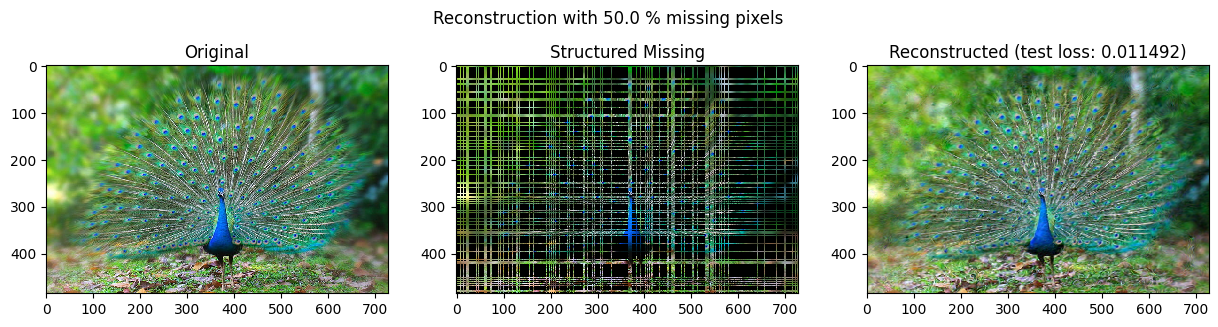

In [47]:
print(f"Test loss: {siren_test_loss:.6f}")

missing_img = siren_tracer.img.clone()
missing_img[siren_tracer.mask] = torch.nan
pred_img_siren = siren_model(siren_tracer.X.to(siren_config.device), siren_tracer.Y.to(siren_config.device)).cpu().detach()

fig, ax = plt.subplots(1, 3, figsize=(15, 3.5))
ax[0].imshow(siren_tracer.img, cmap="gray", interpolation='none')
ax[0].set_title("Original")
ax[1].imshow(missing_img, cmap="gray", interpolation='none')
ax[1].set_title("Structured Missing" if siren_config.structured_missing else "Missing at random")
ax[2].imshow(pred_img_siren.squeeze(), cmap="gray", interpolation='none')
ax[2].set_title(f"Reconstructed (test loss: {siren_test_loss:.6f})");
fig.suptitle(f"Reconstruction with {siren_config.test_fraction*100} % missing pixels")

In [48]:
# # create calibration plot from test pixels, predicted pixels, and uncertainty
# test_pixels = siren_tracer.img[siren_tracer.mask].cpu()
# pred_pixels = pred_img_siren[siren_tracer.mask].cpu()
# pred_std = siren_tracer.pred_std[siren_tracer.mask].cpu()
# print(f"Test pixels: {test_pixels.shape} {test_pixels.numel()/siren_tracer.img.numel()*100:.2f}%")

# def confidence_to_z_score(confidence):
#     return scipy.stats.norm.ppf(1 - (1 - confidence) / 2)

# confidence_range = torch.linspace(0.01, 0.99, 99)
# z_scores = confidence_to_z_score(confidence_range)
# fraction_of_points = []
# quantile = []
# for idx, (z_score, confidence) in enumerate(zip(z_scores, confidence_range)):
#     quantile.append(confidence)
#     fraction = (((pred_pixels + z_score * pred_std) > test_pixels) * (test_pixels > (pred_pixels - z_score * pred_std))).to(torch.float).mean()
#     fraction_of_points.append(fraction)

# fig, ax = plt.subplots(1, 1, figsize=(10, 5))
# ax.plot(quantile, fraction_of_points, label="SIREN (MC dropout)")
# ax.plot([0, 1], [0, 1], linestyle="--", label="Perfect calibration")
# ax.set_xlabel("Quantile")
# ax.set_ylabel("Fraction of points")
# ax.legend();

## Run MF

In [49]:
mf_config = Config()
mf_config.path = siren_config.path
mf_config.key = siren_config.key
mf_config.grayscale = siren_config.grayscale
mf_config.scale_down_factor = siren_config.scale_down_factor
mf_config.iterations = 3000
mf_config.lr = 1e-3
mf_config.regularization = "l2"
mf_config.lmd = 0.0
mf_config.test_fraction = siren_config.test_fraction
mf_config.structured_missing = siren_config.structured_missing
mf_config.device = siren_config.device
mf_config.output_dim = 1 if mf_config.grayscale else 3

# model specific
mf_config.model_class = MatrixFactorization
mf_config.image_shape = missing_img.shape
mf_config.rank = 60

Loss: 0.004545: 100%|██████████| 3000/3000 [00:08<00:00, 334.20it/s]


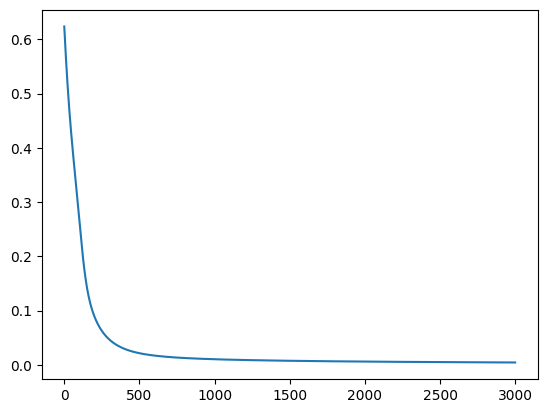

In [50]:
mf_model, mf_losses, mf_test_loss, mf_tracer = run(mf_config, Tracer())
plt.plot(mf_losses)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Test loss: 0.117293


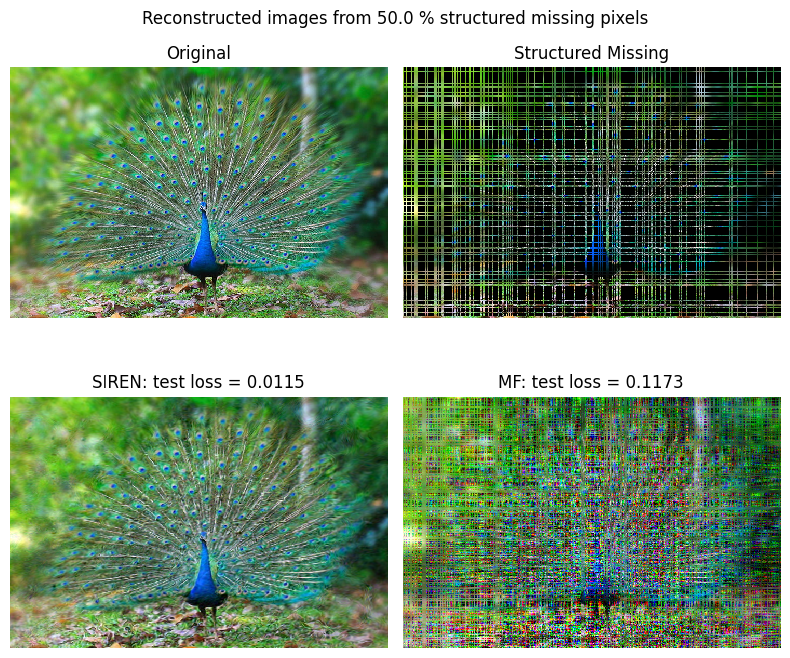

In [51]:
print(f"Test loss: {mf_test_loss:.6f}")

pred_img_mf = mf_model().cpu().detach().numpy()

#create a four figure layout where one figure is in center and others are below it
fig, ax = plt.subplots(2, 2, figsize=(8, 8), gridspec_kw={'height_ratios': [1, 2]})

ax = ax.ravel()
for axis in ax.ravel():
    axis.axis('off')

ax[0].imshow(siren_tracer.img.squeeze(), cmap="gray", interpolation='none')
ax[0].set_title("Original")
ax[1].imshow(missing_img, cmap="gray", interpolation='none')
ax[1].set_title("Structured Missing" if siren_config.structured_missing else "Missing at random")
ax[2].imshow(pred_img_siren.squeeze(), cmap="gray", interpolation='none')
ax[2].set_title(f"SIREN: test loss = {siren_test_loss:.4f}")
ax[3].imshow(pred_img_mf, cmap="gray", interpolation='none')
ax[3].set_title(f"MF: test loss = {mf_test_loss:.4f}");
fig.suptitle(f"Reconstructed images from {mf_config.test_fraction * 100} % {('structured' if mf_config.structured_missing else 'random')} missing pixels");
fig.tight_layout()